### Average Precision

Продолжая тему яблок, возьмем все те же 20 фотографий, на 10 из которых яблоки были, а на 10 яблок не было. И представим, что у нас есть некая нейросеть, которая выдает следующие предсказания по всему датасету (или например по батчу):

In [ ]:
import pandas as pd

nn_preds = pd.DataFrame(
    {
        "IoU": [0.6, 0.98, 0.4, 0.3, 0.1, 0.96, 0.7, 0.3, 0.2, 0.8],
        "precision": [1, 1, 0.67, 0.5, 0.4, 0.5, 0.57, 0.5, 0.44, 0.5],
        "recall": [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1],
    }
)
nn_preds

,IoU,precision,recall
0,0.60,1.00,0.2
1,0.98,1.00,0.4
2,0.40,0.67,0.4
3,0.30,0.50,0.4
4,0.10,0.40,0.4
5,0.96,0.50,0.6
6,0.70,0.57,0.8
7,0.30,0.50,0.8
8,0.20,0.44,0.8
9,0.80,0.50,1.0


Будем считать, что если $\mathrm{IoU} \geq 0.5$, то предсказание правильное.

[Еще раз про то как считать IoU](https://github.com/Gan4x4/ml_snippets/blob/main/Training/IoU_from_L12.ipynb)

In [ ]:
nn_preds["correct"] = False
nn_preds.loc[nn_preds["IoU"] >= 0.5, "correct"] = True

nn_preds

,IoU,precision,recall,correct
0,0.60,1.00,0.2,True
1,0.98,1.00,0.4,True
2,0.40,0.67,0.4,False
3,0.30,0.50,0.4,False
4,0.10,0.40,0.4,False
5,0.96,0.50,0.6,True
6,0.70,0.57,0.8,True
7,0.30,0.50,0.8,False
8,0.20,0.44,0.8,False
9,0.80,0.50,1.0,True


Можно заметить, что precision имеет зигзагообразный характер: она снижается при ложных срабатываниях и снова повышается при истинных срабатываниях.

Давайте построим график precision от recall и убедимся:

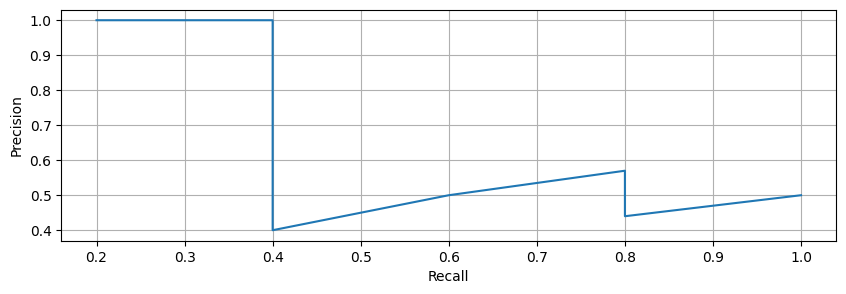

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(nn_preds.recall, nn_preds.precision)
ax.grid("on")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

По определению, чтобы найти AP, нужно найти площадь под кривой recall-precision:

$\displaystyle AP = \int_0^1p(r)dr$



Precision и recall всегда находятся в пределах от 0 до 1. Поэтому $AP$ также находится в пределах от 0 до 1. Перед расчетом $AP$ для обнаружения объекта мы часто сначала сглаживаем зигзагообразный рисунок (на каждом уровне recall мы заменяем каждое значение precision максимальным значением точности справа от этого уровня отзыва).

In [ ]:
def smooth_precision(nn_preds):
    smooth_prec = []
    for i in range(len(nn_preds.precision.values)):
        max = nn_preds.precision.values[i:].max()
        smooth_prec.append(max)
    nn_preds["smooth_precision"] = smooth_prec
    return nn_preds


nn_preds = smooth_precision(nn_preds)

Давайте посмотрим, как это выглядит на графике:

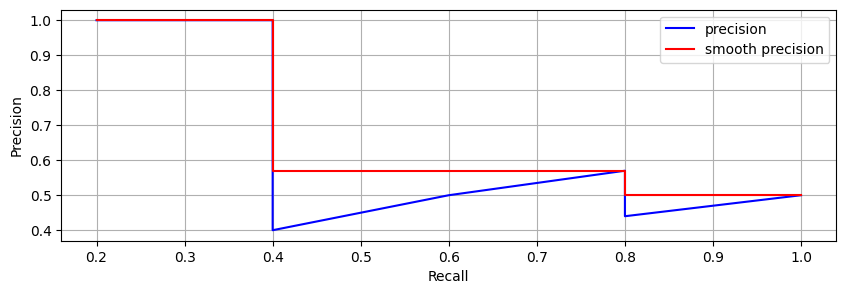

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(nn_preds.recall, nn_preds.precision, label="precision", color="blue")
ax.plot(
    nn_preds.recall, nn_preds.smooth_precision, label="smooth precision", color="red"
)
ax.grid("on")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.show()

Зачем нам нужно сглаживание? Чтобы снизить влияние случайных выбросов и "прыжков" в предсказаниях модели.

Теперь давайте посчитаем-таки $AP$:

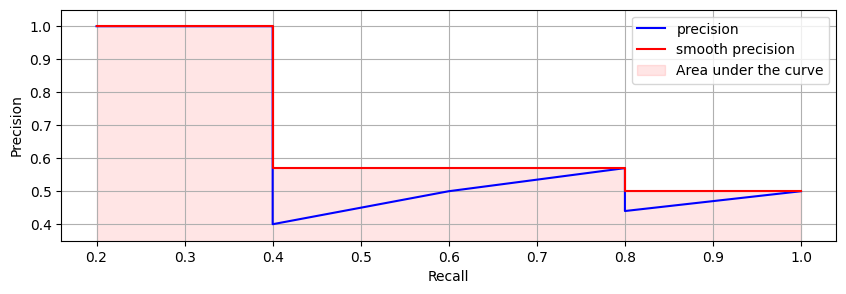

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(nn_preds.recall, nn_preds.precision, label="precision", color="blue")
ax.plot(
    nn_preds.recall, nn_preds.smooth_precision, label="smooth precision", color="red"
)
ax.fill_between(
    nn_preds.recall,
    nn_preds.smooth_precision,
    np.zeros_like(nn_preds.smooth_precision),
    color="red",
    alpha=0.1,
    label="Area under the curve",
)
ax.grid("on")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_ylim(0.35, 1.05)
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import auc

AP = auc(nn_preds.recall, nn_preds.smooth_precision)

print("AP = %.2f" % AP)

AP = 0.53


### COCO mAP

В последних исследовательских работах как правило приводятся результаты только для набора данных COCO. Для COCO AP — это среднее значение (*mean*) по нескольким IoU (минимальный IoU, который следует считать положительным совпадением). AP@[.5:.95] соответствует среднему AP для IoU от 0.5 до 0.95 с шагом 0.05.

Давайте попробуем посчитать mAP. Для этого посчитаем AP для каждого уровня IoU:

In [ ]:
nn_prediction_at_iou = []
APs = []
for iou in np.arange(0.5, 1, 0.05):
    nn_preds_limited = nn_preds[nn_preds["IoU"] >= iou].copy()
    nn_preds_limited = smooth_precision(nn_preds_limited)
    AP = auc(nn_preds_limited.recall, nn_preds_limited.smooth_precision)
    APs.append(AP)

mAP@[0.5:0.95] = 0.32


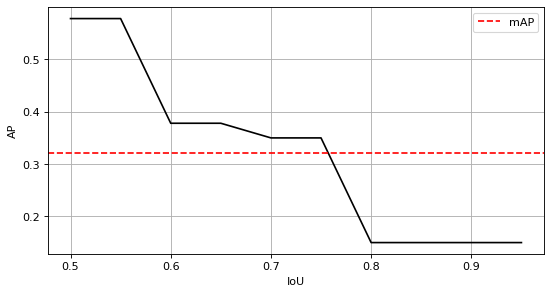

In [ ]:
plt.figure(figsize=(8, 4), dpi=80)

plt.plot(np.arange(0.5, 1, 0.05), APs, color="black")
plt.axhline(np.mean(APs), color="red", ls="--", label="mAP")
plt.xlabel("IoU")
plt.ylabel("AP")
plt.grid("on")
plt.legend()

print("mAP@[0.5:0.95] = %.2f" % np.mean(APs))
plt.show()

Есть несколько различных определений mAP, которые разнятся от соревнования к соревнованию (суть одинаковая, но разница в деталях подхода), поэтому для каждого соревнования лучше использовать их собственные библиотеки для расчета

### Focal loss

Одним из интересных способов борьбы с падением качества работы модели на нестандартных данных, является уже упомянутый **Focal Loss**.
При использовании кросс-энтропии, loss от большого количества "хорошо распознанных" примеров суммарно может быть более значительным, чем loss от малого количества "плохо распознанных" примеров. Итого, при обучении модель стремится снизить свою ошибку на большинстве и так уже неплохо предсказываемых примеров, не стремясь исправлять высокую ошибку на редких примерах.

Идея **Focal Loss** заключается в том, что можно попробовать снизить значения **Cross-Entropy Loss** на и так уже неплохо предсказываемых примерах, чтобы дать модели возможность лучше обучиться на "сложных" для неё примерах.

Давайте посчитаем для различных значений $γ$, сколько понадобится примеров с небольшой ошибкой, чтобы получить суммарный **Focal Loss** примерно такой же, как у одного примера с большой ошибкой.

In [ ]:
def cross_entropy(percent_correct):
    return -np.log(percent_correct)


def focal_loss(percent_correct, gamma=5):
    return cross_entropy(percent_correct) * (1 - percent_correct) ** gamma


p1 = 0.8  # probability for correct examples predictions
p2 = 0.4  # probability for hard examples predictions
gammas = [0, 1, 5, 9, 13, 17]

print(
    f"For probability for correct examples predictions {p1} and probability for hard examples predictions {p2}\n"
)

for gamma in gammas:
    fl1 = focal_loss(p1, gamma)
    fl2 = focal_loss(p2, gamma)

    print(
        f"gamma = {gamma},".ljust(15),
        f"for an equal loss with a problematic prediction, almost correct ones are required {int(fl2 / fl1)}",
    )

For probability for correct examples predictions 0.8 and probability for hard examples predictions 0.4

gamma = 0,      for an equal loss with a problematic prediction, almost correct ones are required 4
gamma = 1,      for an equal loss with a problematic prediction, almost correct ones are required 12
gamma = 5,      for an equal loss with a problematic prediction, almost correct ones are required 997
gamma = 9,      for an equal loss with a problematic prediction, almost correct ones are required 80823
gamma = 13,     for an equal loss with a problematic prediction, almost correct ones are required 6546742
gamma = 17,     for an equal loss with a problematic prediction, almost correct ones are required 530286148


Как видно, при увеличении значения $\gamma$ можно достичь значительного роста "важности" примеров с высокой ошибкой, что, по сути, позволяет модели обращать внимание на "hard examples".

[Training Region-based Object Detectors with Online Hard Example Mining (Shrivastava et al., 2016)](https://paperswithcode.com/method/ohem)

[Loss Rank Mining: A General Hard ExampleMining Method for Real-time Detectors (Yu et al., 2018)](https://arxiv.org/abs/1804.04606)